### Financial Index Prediction
This notebook seeks to predict if an ARMA model predicts a higher or lower price than the actual outcome. News from day $k$ are used to evaluate the outcome on day $k$. A range of different combinations between statistical and NLP-models are used. 

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import parallel_backend
from pathlib import Path
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from tqdm import tqdm, trange
from sklearn.dummy import DummyClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#### Load financial news data and financial index data

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
# Read from 2006-10-20 for next day preds or from 2006-10-19 for current day preds
fin_data = fin_data.loc['2006-10-20' : '2013-11-22']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

In [3]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates()

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
        
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for date in valid_dates: 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.loc[date]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.loc[date]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.loc[date]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.loc[date]

In [4]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for date in tqdm(valid_dates): 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        if i < len(news_data.loc[date]['title']) - 1:
            temp_texts += text + ". "
        else:
            temp_texts += text
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))

100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:56<00:00, 32.95it/s]

Length of texts: 1846
Length of targets: 1846


In [14]:
arma_path = Path(os.getcwd()).parent / "arma_labels.npy"
arma_labels = np.load(arma_path)
# Replace the targets 
for i in range(len(targets)): 
    targets.iloc[i]['1 YEAR'] = arma_labels[i,0]
    targets.iloc[i]['3 YEAR'] = arma_labels[i,1]
    targets.iloc[i]['S&P'] = arma_labels[i,2]
    
# Drop first line of texts and last line of targets to shift 
texts = texts[1:]
targets = targets.drop(1845)

#### Format the text with tf-idf
The texts have now been separated into entries in a arrays for training and testing. The next step is to transform these entries into vectors using TF-IDF. 

In [15]:
# Create a matrix with the frequency of a word in each day.
count_vec = CountVectorizer(max_features=10000) # Includes only the 10000 most frequent words 
count_vec.fit(texts)

x_count = count_vec.transform(texts)
x_count = count_vec.transform(texts)

# Create a matrix with the tfidf representation of the text
tfidf_vec = TfidfTransformer()
tfidf_vec.fit(x_count)
x = tfidf_vec.transform(x_count)

#### Partition into training and test set
Since the data is somewhat imbalanced - mostly for the 1 year rate - the training data will be under sampled by the minority class. 

In [16]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), *"Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.610840108401084
Neg labels: 1127 P o s   l a b e l s : 718
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.5382113821138211
Neg labels: 993 Pos labels: 852
 -----     S&P     -----
Ratio neg labels S&P: 0.5506775067750678
Neg labels: 1016 Pos labels: 829


In [17]:
n_train = 1200
n = len(targets)

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

texts_train_1yr = texts[train_indices_1yr]
texts_test_1yr = texts[test_indices_1yr]
x_train_1yr = x[train_indices_1yr]
x_test_1yr = x[test_indices_1yr]
y_train_1yr = targets.iloc[train_indices_1yr]['1 YEAR'].values
y_test_1yr = targets.iloc[test_indices_1yr]['1 YEAR'].values

texts_train_3yr = texts[train_indices_3yr]
texts_test_3yr = texts[test_indices_3yr]
x_train_3yr = x[train_indices_3yr]
x_test_3yr = x[test_indices_3yr]
y_train_3yr = targets.iloc[train_indices_3yr]['3 YEAR'].values
y_test_3yr = targets.iloc[test_indices_3yr]['3 YEAR'].values

texts_train_sp = texts[train_indices_sp]
texts_test_sp = texts[test_indices_sp]
x_train_sp = x[train_indices_sp]
x_test_sp = x[test_indices_sp]
y_train_sp = targets.iloc[train_indices_sp]['S&P'].values
y_test_sp = targets.iloc[test_indices_sp]['S&P'].values

# Sanity check of shapes 

print(" ----- 1 YEAR RATE -----")
print("Train data shape (x,y):",x_train_1yr.shape,",", y_train_1yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data shape (x,y):",x_test_1yr.shape,",", y_test_1yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data shape (x,y):",x_train_3yr.shape,",", y_train_3yr.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data shape (x,y):",x_test_3yr.shape,",", y_test_3yr.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data shape (x,y):",x_train_sp.shape,",", y_train_sp.shape)
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data shape (x,y):",x_test_sp.shape,",", y_test_sp.shape)
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data shape (x,y): (1200, 10000) , (1200,)
Train data label ratio (0 / 1): 733 / 467
Test data shape (x,y): (645, 10000) , (645,)
Test data label ratio (0 / 1): 394 / 251
 ----- 3 YEAR RATE -----
Train data shape (x,y): (1200, 10000) , (1200,)
Train data label ratio (0 / 1): 646 / 554
Test data shape (x,y): (645, 10000) , (645,)
Test data label ratio (0 / 1): 347 / 298
 -----     S&P     -----
Train data shape (x,y): (1200, 10000) , (1200,)
Train data label ratio (0 / 1): 661 / 539
Test data shape (x,y): (645, 10000) , (645,)
Test data label ratio (0 / 1): 355 / 290


## Models 
The data has been pre-processed and the models can be evaluated. All of the models are fitted with the three data series. 

In [18]:
# Some help functions for plotting the results 

def plot_results(model,x_test, y_test,save=False, name=''):
    y_test_preds = model.predict(x_test)
    print(classification_report(y_test, y_test_preds))
    print("Test accuracy:",model.score(x_test, y_test))
    plot_confusion_matrix(model,x_test,y_test)
    if save:
        plt.savefig("Figs TF-IDF/" + name + "confmat.jpg")
    plt.show()
    
def plot_results_nn(history, model,x_test, y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs TF-IDF/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict(x_test.todense()))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs TF-IDF/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

### Random Classifier
Just for real simple comparison. 
#### 1 year rate

C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       394
         1.0       0.00      0.00      0.00       251

    accuracy                           0.61       645
   macro avg       0.31      0.50      0.38       645
weighted avg       0.37      0.61      0.46       645

Test accuracy: 0.6108527131782946


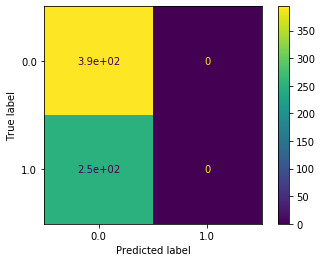

In [19]:
# Dummy Classifier, most frequent
dummy_clf_1yr = DummyClassifier(strategy='most_frequent').fit(x_train_1yr, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59       394
         1.0       0.35      0.36      0.36       251

    accuracy                           0.50       645
   macro avg       0.47      0.47      0.47       645
weighted avg       0.50      0.50      0.50       645

Test accuracy: 0.5441860465116279


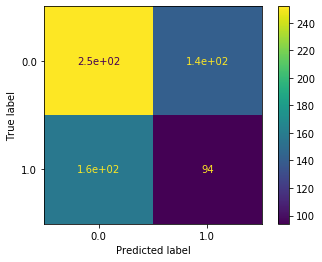

In [20]:
# Dummy Classifier, stratified
dummy_clf_1yr = DummyClassifier(strategy='stratified').fit(x_train_1yr, y_train_1yr)
plot_results(dummy_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='randclf_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       347
         1.0       0.00      0.00      0.00       298

    accuracy                           0.54       645
   macro avg       0.27      0.50      0.35       645
weighted avg       0.29      0.54      0.38       645

Test accuracy: 0.537984496124031


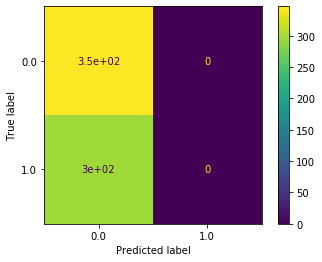

In [21]:
# Dummy Classifier, most frequent
dummy_clf_3yr = DummyClassifier(strategy='most_frequent').fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

              precision    recall  f1-score   support

         0.0       0.55      0.52      0.53       347
         1.0       0.47      0.50      0.49       298

    accuracy                           0.51       645
   macro avg       0.51      0.51      0.51       645
weighted avg       0.51      0.51      0.51       645

Test accuracy: 0.5038759689922481


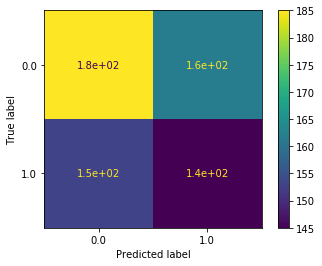

In [22]:
# Dummy Classifier, stratified
dummy_clf_3yr = DummyClassifier(strategy='stratified').fit(x_train_3yr, y_train_3yr)
plot_results(dummy_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='randclf_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.55      1.00      0.71       355
         1.0       0.00      0.00      0.00       290

    accuracy                           0.55       645
   macro avg       0.28      0.50      0.35       645
weighted avg       0.30      0.55      0.39       645

Test accuracy: 0.5503875968992248


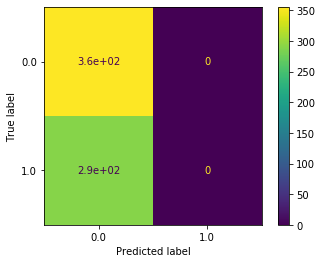

In [23]:
# Dummy Classifier, most frequent
dummy_clf_sp = DummyClassifier(strategy='most_frequent').fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

              precision    recall  f1-score   support

         0.0       0.54      0.55      0.54       355
         1.0       0.43      0.41      0.42       290

    accuracy                           0.49       645
   macro avg       0.48      0.48      0.48       645
weighted avg       0.49      0.49      0.49       645

Test accuracy: 0.5286821705426357


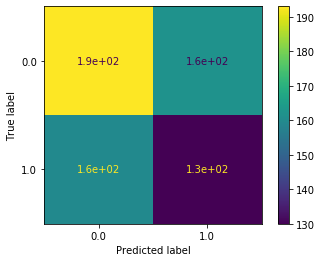

In [24]:
# Dummy Classifier, stratified
dummy_clf_sp = DummyClassifier(strategy='stratified').fit(x_train_sp, y_train_sp)
plot_results(dummy_clf_sp, x_test_sp, y_test_sp,save=True,name='randclf_sp')

### Logistic Regression with TF-IDF
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.63      0.92      0.75       394
         1.0       0.56      0.15      0.24       251

    accuracy                           0.62       645
   macro avg       0.59      0.54      0.49       645
weighted avg       0.60      0.62      0.55       645

Test accuracy: 0.6232558139534884


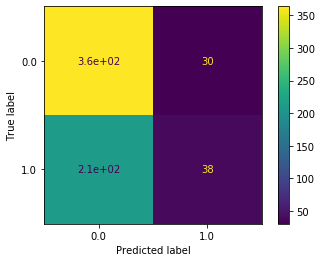

In [25]:
# Logistic regression
logreg_1yr = LogisticRegression(random_state=0).fit(x_train_1yr, y_train_1yr)
plot_results(logreg_1yr,x_test_1yr, y_test_1yr,save=True,name='logreg_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.56      0.77      0.65       347
         1.0       0.52      0.30      0.38       298

    accuracy                           0.55       645
   macro avg       0.54      0.53      0.51       645
weighted avg       0.54      0.55      0.52       645

Test accuracy: 0.5503875968992248


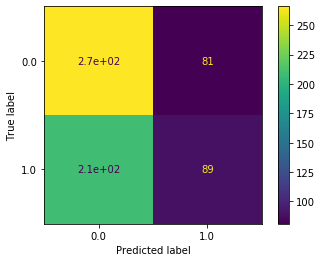

In [26]:
# Logistic regression
logreg_3yr = LogisticRegression(random_state=0).fit(x_train_3yr, y_train_3yr)
plot_results(logreg_3yr,x_test_3yr, y_test_3yr,save=True,name='logreg_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.56      0.83      0.67       355
         1.0       0.49      0.20      0.29       290

    accuracy                           0.55       645
   macro avg       0.53      0.52      0.48       645
weighted avg       0.53      0.55      0.50       645

Test accuracy: 0.5472868217054263


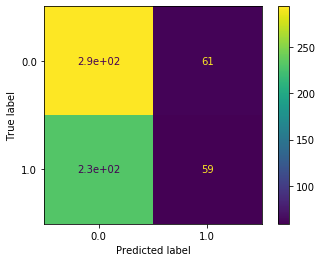

In [27]:
# Logistic regression
logreg_sp = LogisticRegression(random_state=0).fit(x_train_sp, y_train_sp)
plot_results(logreg_sp,x_test_sp, y_test_sp,save=True,name='logreg_sp')

### Support Vector Machine with TF-IDF
#### 1 year rate

              precision    recall  f1-score   support

         0.0       0.63      0.96      0.76       394
         1.0       0.60      0.10      0.17       251

    accuracy                           0.62       645
   macro avg       0.61      0.53      0.46       645
weighted avg       0.61      0.62      0.53       645

Test accuracy: 0.6232558139534884


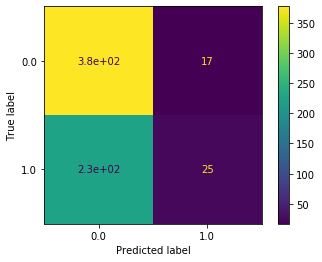

In [28]:
svm_clf_1yr = svm.SVC().fit(x_train_1yr, y_train_1yr)
plot_results(svm_clf_1yr, x_test_1yr, y_test_1yr,save=True,name='svm_1yr')

#### 3 year rate

              precision    recall  f1-score   support

         0.0       0.56      0.88      0.69       347
         1.0       0.59      0.20      0.30       298

    accuracy                           0.57       645
   macro avg       0.58      0.54      0.49       645
weighted avg       0.57      0.57      0.51       645

Test accuracy: 0.5658914728682171


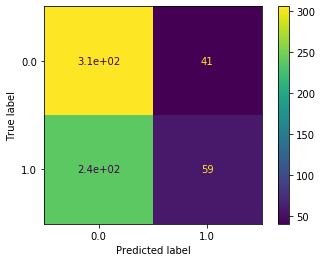

In [29]:
svm_clf_3yr = svm.SVC().fit(x_train_3yr, y_train_3yr)
plot_results(svm_clf_3yr, x_test_3yr, y_test_3yr,save=True,name='svm_3yr')

#### S&P

              precision    recall  f1-score   support

         0.0       0.56      0.93      0.70       355
         1.0       0.58      0.12      0.20       290

    accuracy                           0.57       645
   macro avg       0.57      0.53      0.45       645
weighted avg       0.57      0.57      0.48       645

Test accuracy: 0.5658914728682171


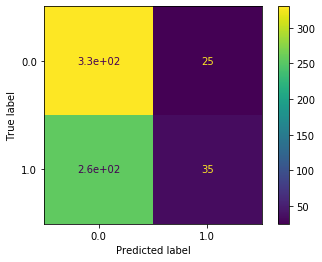

In [30]:
svm_clf_sp = svm.SVC().fit(x_train_sp, y_train_sp)
plot_results(svm_clf_sp, x_test_sp, y_test_sp,save=True,name='svm_sp')

### Random Forest with TF-IDF
#### 1 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.7min finished


Best: 0.524570 using {'max_depth': 50, 'n_estimators': 250}
0.511491 (0.016311) with: {'max_depth': None, 'n_estimators': 250}
0.512555 (0.022302) with: {'max_depth': None, 'n_estimators': 500}
0.510557 (0.031554) with: {'max_depth': None, 'n_estimators': 750}
0.503009 (0.028069) with: {'max_depth': None, 'n_estimators': 1000}
0.524570 (0.029523) with: {'max_depth': 50, 'n_estimators': 250}
0.493546 (0.032426) with: {'max_depth': 50, 'n_estimators': 500}
0.505142 (0.028046) with: {'max_depth': 50, 'n_estimators': 750}
0.505649 (0.025511) with: {'max_depth': 50, 'n_estimators': 1000}
0.517839 (0.032215) with: {'max_depth': 100, 'n_estimators': 250}
0.513649 (0.032061) with: {'max_depth': 100, 'n_estimators': 500}
0.515321 (0.046582) with: {'max_depth': 100, 'n_estimators': 750}
0.504595 (0.024227) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.62      0.96      0.75       394
         1.0       0.57      0.09   

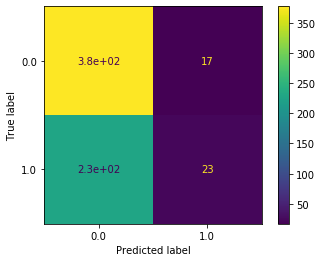

In [31]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_1yr, y_train_1yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_1yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_1yr, y_train_1yr)
plot_results(randomforest_1yr,x_test_1yr, y_test_1yr,save=True,name='rf_1yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### 3 year rate

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  5.9min finished


Best: 0.515349 using {'max_depth': None, 'n_estimators': 250}
0.515349 (0.036285) with: {'max_depth': None, 'n_estimators': 250}
0.501339 (0.043141) with: {'max_depth': None, 'n_estimators': 500}
0.510194 (0.041235) with: {'max_depth': None, 'n_estimators': 750}
0.499073 (0.045961) with: {'max_depth': None, 'n_estimators': 1000}
0.509190 (0.035397) with: {'max_depth': 50, 'n_estimators': 250}
0.489239 (0.033547) with: {'max_depth': 50, 'n_estimators': 500}
0.506337 (0.039266) with: {'max_depth': 50, 'n_estimators': 750}
0.494279 (0.033589) with: {'max_depth': 50, 'n_estimators': 1000}
0.491802 (0.040675) with: {'max_depth': 100, 'n_estimators': 250}
0.505384 (0.026442) with: {'max_depth': 100, 'n_estimators': 500}
0.490259 (0.030892) with: {'max_depth': 100, 'n_estimators': 750}
0.503370 (0.030647) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.55      0.75      0.63       347
         1.0       0.49      0.28 

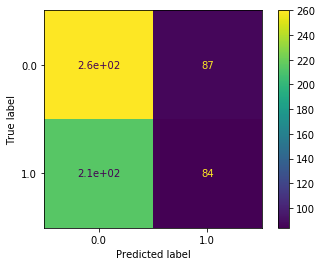

In [32]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid,
                       n_jobs=-1,
                       cv=10,
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_3yr, y_train_3yr)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_3yr = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_3yr, y_train_3yr)
plot_results(randomforest_3yr,x_test_3yr, y_test_3yr,save=True,name='rf_3yr_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

#### S&P

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.1min finished


Best: 0.507136 using {'max_depth': 100, 'n_estimators': 250}
0.476822 (0.033669) with: {'max_depth': None, 'n_estimators': 250}
0.499518 (0.039205) with: {'max_depth': None, 'n_estimators': 500}
0.494670 (0.027323) with: {'max_depth': None, 'n_estimators': 750}
0.502406 (0.026507) with: {'max_depth': None, 'n_estimators': 1000}
0.498212 (0.036341) with: {'max_depth': 50, 'n_estimators': 250}
0.474165 (0.032224) with: {'max_depth': 50, 'n_estimators': 500}
0.497512 (0.026635) with: {'max_depth': 50, 'n_estimators': 750}
0.490321 (0.026104) with: {'max_depth': 50, 'n_estimators': 1000}
0.507136 (0.033164) with: {'max_depth': 100, 'n_estimators': 250}
0.493499 (0.023588) with: {'max_depth': 100, 'n_estimators': 500}
0.496019 (0.030412) with: {'max_depth': 100, 'n_estimators': 750}
0.504434 (0.036958) with: {'max_depth': 100, 'n_estimators': 1000}
              precision    recall  f1-score   support

         0.0       0.56      0.89      0.69       355
         1.0       0.52      0.15  

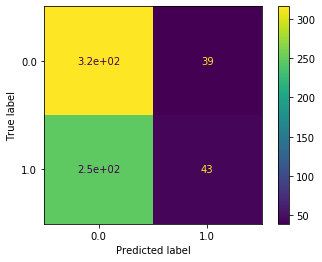

In [33]:
# Random Forest
rf_param_grid = dict(max_depth=[None, 50, 100],
                  n_estimators=[250, 500, 750, 1000])
rf_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                       param_grid=rf_param_grid, 
                       n_jobs=-1, 
                       cv=10, 
                       scoring='f1_weighted',
                       verbose=1)
with parallel_backend('threading'):    # This is a bug work-around mentioned in https://github.com/scikit-learn/scikit-learn/issues/12546
    rf_grid_result = rf_grid.fit(x_train_sp, y_train_sp)
# summarize results
print("Best: %f using %s" % (rf_grid_result.best_score_, rf_grid_result.best_params_))
rf_means = rf_grid_result.cv_results_['mean_test_score']
rf_stds = rf_grid_result.cv_results_['std_test_score']
rf_params = rf_grid_result.cv_results_['params']
for mean, stdev, param in zip(rf_means, rf_stds, rf_params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Fit the model with the best parameters found in the cross validation. 
randomforest_sp = RandomForestClassifier(max_depth=rf_grid_result.best_params_['max_depth'],
                                      n_estimators=rf_grid_result.best_params_['n_estimators']).fit(x_train_sp, y_train_sp)
plot_results(randomforest_sp,x_test_sp, y_test_sp,save=True,name='rf_sp_md{}_est_{}'.format(rf_grid_result.best_params_['max_depth'],
                                                                                rf_grid_result.best_params_['n_estimators']))

### Neural Network

In [34]:
def create_model(nodes1=100, nodes2=50, dropout_rate=0.3, optimizer='rmsprop', learning_rate=0.001):
    if optimizer.lower() == 'rmsprop': 
        optimizer = RMSprop(learning_rate = learning_rate)
    elif optimizer.lower() == 'adam':
        optimizer = Adam(learning_rate = learning_rate)
    model = Sequential() 
    if nodes1 == 0: 
        model.add(Dense(1, input_shape=x_train_1yr.shape[1:], activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model 
    model.add(Dense(nodes1, input_shape=x_train_1yr.shape[1:]))
    model.add(Dropout(dropout_rate))
    if nodes2 == 0: 
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
        return model
    model.add(Dense(nodes2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model 

def randomize_params(params, n):
    test_params = []
    for i in range(n):
        temp_par = {}
        while True: 
            for par in params: 
                temp_par.update({par: np.random.choice(params[par])})
            if temp_par not in test_params: 
                test_params.append(temp_par)
                break
    return test_params

In [35]:
n_tests = 50
# Define possible parameters 
possible_params = dict(batch_size = [8, 16, 32],
                       nodes1 = [50, 100, 250, 500],
                       nodes2 = [0, 50, 100, 250, 500], # 0 implies only one hidden layer 
                       dropout_rate = [0.1, 0.3, 0.5],
                       learning_rate = [1e-3, 1e-4, 1e-5],
                       optimizer = ['RMSprop','Adam'])
test_params = randomize_params(possible_params, n_tests)

#### 1 year rate

In [36]:
historylist_1yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_1yr, y_train_1yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_1yr.append(history)
max_acc_1yr = -1
max_idx_1yr = -1
for i,hist in enumerate(historylist_1yr):
    if max(hist.history['val_acc']) > max_acc_1yr: 
        max_acc_1yr = max(hist.history['val_acc'])
        max_idx_1yr = i
    
print("Best val acc:",max_acc_1yr)
print("For config: ",test_params[max_idx_1yr])

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:09<00:00,  8.59s/it]

Best val acc: 0.62916666
For config:  {'nodes1': 50, 'nodes2': 500, 'dropout_rate': 0.5, 'learning_rate': 1e-05, 'optimizer': 'Adam', 'batch_size': 16}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 2s 2ms/sample - loss: 0.6934 - acc: 0.5031 - val_loss: 0.6926 - val_acc: 0.5542
Epoch 2/100000
960/960 [==============================] - 0s 501us/sample - loss: 0.6912 - acc: 0.5792 - val_loss: 0.6911 - val_acc: 0.5917
Epoch 3/100000
960/960 [==============================] - 1s 538us/sample - loss: 0.6893 - acc: 0.6104 - val_loss: 0.6897 - val_acc: 0.6000
Epoch 4/100000
960/960 [==============================] - 1s 545us/sample - loss: 0.6877 - acc: 0.6135 - val_loss: 0.6884 - val_acc: 0.6000
Epoch 5/100000
960/960 [==============================] - 1s 554us/sample - loss: 0.6856 - acc: 0.6135 - val_loss: 0.6871 - val_acc: 0.6000
Epoch 6/100000
960/960 [==============================] - 1s 522us/sample - loss: 0.6845 - acc: 0.6135 - val_loss: 0.6860 - val_acc: 0.6000
Epoch 7/100000
960/960 [==============================] - 1s 538us/sample - loss: 0.6819 - acc: 0.6135 - val_loss: 0

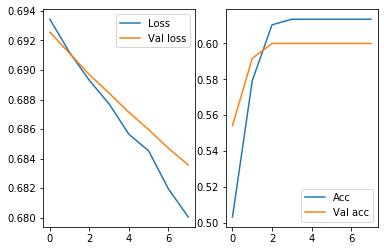

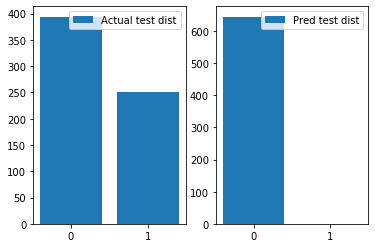

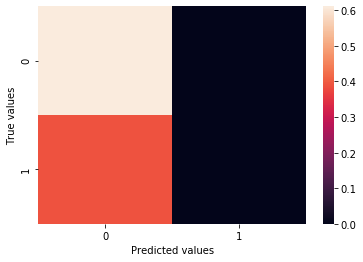

              precision    recall  f1-score   support

         0.0       0.61      1.00      0.76       394
         1.0       0.00      0.00      0.00       251

    accuracy                           0.61       645
   macro avg       0.31      0.50      0.38       645
weighted avg       0.37      0.61      0.46       645

Test accuracy: 0.611


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
bs = test_params[max_idx_1yr].pop('batch_size')
model_ff_1yr = create_model(**test_params[max_idx_1yr])
test_params[max_idx_1yr].update({'batch_size': bs})

history_1yr = model_ff_1yr.fit(x_train_1yr, y_train_1yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                               validation_split=0.2)
savename_1yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_1yr]['batch_size'],
                                                          test_params[max_idx_1yr]['nodes1'],
                                                          test_params[max_idx_1yr]['nodes2'],
                                                          test_params[max_idx_1yr]['dropout_rate'],
                                                          test_params[max_idx_1yr]['learning_rate'],
                                                          test_params[max_idx_1yr]['optimizer'])
plot_results_nn(history_1yr,model_ff_1yr,x_test_1yr, y_test_1yr,save=True, name=savename_1yr)

#### 3 year rate

In [38]:
historylist_3yr = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_3yr, y_train_3yr,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_3yr.append(history)
max_acc_3yr = -1
max_idx_3yr = -1
for i,hist in enumerate(historylist_3yr):
    if max(hist.history['val_acc']) > max_acc_3yr: 
        max_acc_3yr = max(hist.history['val_acc'])
        max_idx_3yr = i
    
print("Best val acc:",max_acc_3yr)
print("For config: ",test_params[max_idx_3yr])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [13:48<00:00, 16.56s/it]

Best val acc: 0.5541667
For config:  {'nodes1': 250, 'nodes2': 250, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 8}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 9s 9ms/sample - loss: 0.6926 - acc: 0.5427 - val_loss: 0.6923 - val_acc: 0.4958
Epoch 2/100000
960/960 [==============================] - 4s 4ms/sample - loss: 0.4691 - acc: 0.8104 - val_loss: 0.9339 - val_acc: 0.5083
Epoch 3/100000
960/960 [==============================] - 4s 4ms/sample - loss: 0.0994 - acc: 0.9677 - val_loss: 1.5391 - val_acc: 0.4792
Epoch 4/100000
960/960 [==============================] - 4s 4ms/sample - loss: 0.0110 - acc: 0.9948 - val_loss: 2.6353 - val_acc: 0.4958
Epoch 5/100000
960/960 [==============================] - 4s 4ms/sample - loss: 1.5045e-04 - acc: 1.0000 - val_loss: 3.1514 - val_acc: 0.5208
Epoch 6/100000
960/960 [==============================] - 4s 5ms/sample - loss: 1.5037e-06 - acc: 1.0000 - val_loss: 4.3449 - val_acc: 0.4667
Epoch 7/100000
960/960 [==============================] - 4s 4ms/sample - loss: 2.7131e-07 - acc: 1.0000 - val_loss: 3

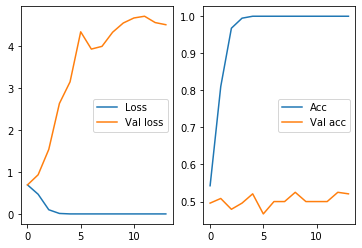

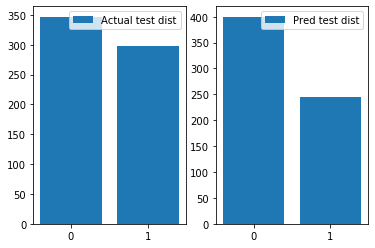

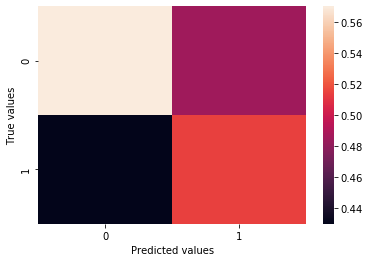

              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61       347
         1.0       0.51      0.42      0.46       298

    accuracy                           0.55       645
   macro avg       0.54      0.54      0.54       645
weighted avg       0.54      0.55      0.54       645

Test accuracy: 0.549


In [39]:
bs = test_params[max_idx_3yr].pop('batch_size')
model_ff_3yr = create_model(**test_params[max_idx_3yr])
test_params[max_idx_3yr].update({'batch_size': bs})

history_3yr = model_ff_3yr.fit(x_train_3yr, y_train_3yr,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                               validation_split=0.2)
savename_3yr = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_3yr]['batch_size'],
                                                          test_params[max_idx_3yr]['nodes1'],
                                                          test_params[max_idx_3yr]['nodes2'],
                                                          test_params[max_idx_3yr]['dropout_rate'],
                                                          test_params[max_idx_3yr]['learning_rate'],
                                                          test_params[max_idx_3yr]['optimizer'])
plot_results_nn(history_3yr,model_ff_3yr,x_test_3yr, y_test_3yr,save=True, name=savename_3yr)


#### S&P

In [40]:
historylist_sp = []
for i,params in enumerate(tqdm(test_params)): 
    bs = params.pop('batch_size')
    model = create_model(**params)
    params.update({'batch_size': bs})
    history = model.fit(x_train_sp, y_train_sp,
                        epochs=10000,
                        batch_size=params['batch_size'],
                        verbose=0,
                        callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)],
                        validation_split=0.2)
    historylist_sp.append(history)
max_acc_sp = -1
max_idx_sp = -1
for i,hist in enumerate(historylist_sp):
    if max(hist.history['val_acc']) > max_acc_sp: 
        max_acc_sp = max(hist.history['val_acc'])
        max_idx_sp = i
    
print("Best val acc:",max_acc_sp)
print("For config: ",test_params[max_idx_sp])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [21:15<00:00, 25.51s/it]

Best val acc: 0.59166664
For config:  {'nodes1': 250, 'nodes2': 500, 'dropout_rate': 0.1, 'learning_rate': 0.0001, 'optimizer': 'RMSprop', 'batch_size': 16}


Train on 960 samples, validate on 240 samples
Epoch 1/100000
960/960 [==============================] - 9s 10ms/sample - loss: 0.6902 - acc: 0.5417 - val_loss: 0.6866 - val_acc: 0.5500
Epoch 2/100000
960/960 [==============================] - 4s 4ms/sample - loss: 0.6733 - acc: 0.5510 - val_loss: 0.6851 - val_acc: 0.5500
Epoch 3/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.6382 - acc: 0.5927 - val_loss: 0.6836 - val_acc: 0.5833
Epoch 4/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.5654 - acc: 0.8125 - val_loss: 0.6859 - val_acc: 0.5500
Epoch 5/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.4550 - acc: 0.9146 - val_loss: 0.7033 - val_acc: 0.5208
Epoch 6/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.3318 - acc: 0.9635 - val_loss: 0.7303 - val_acc: 0.5375
Epoch 7/100000
960/960 [==============================] - 3s 3ms/sample - loss: 0.2177 - acc: 0.9823 - val_loss: 0.7877 - val

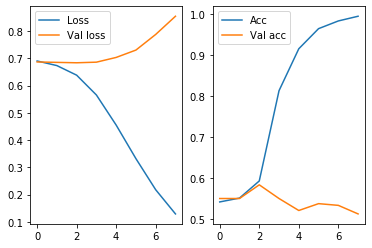

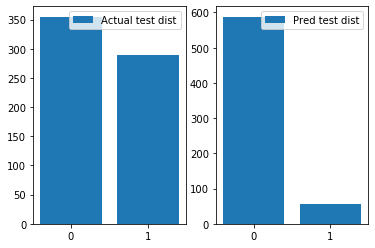

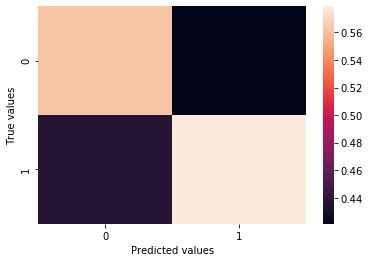

              precision    recall  f1-score   support

         0.0       0.56      0.93      0.70       355
         1.0       0.58      0.11      0.19       290

    accuracy                           0.56       645
   macro avg       0.57      0.52      0.45       645
weighted avg       0.57      0.56      0.47       645

Test accuracy: 0.564


In [41]:
bs = test_params[max_idx_sp].pop('batch_size')
model_ff_sp = create_model(**test_params[max_idx_sp])
test_params[max_idx_sp].update({'batch_size': bs})

history_sp = model_ff_sp.fit(x_train_sp, y_train_sp,
                               epochs=100000,
                               batch_size = bs,
                               verbose=1,
                               callbacks = [EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True)],
                               validation_split=0.2)
savename_sp = "nn_bs{}_n1{}_n2{}_dr{}_lr{}_opt{}".format(test_params[max_idx_sp]['batch_size'],
                                                          test_params[max_idx_sp]['nodes1'],
                                                          test_params[max_idx_sp]['nodes2'],
                                                          test_params[max_idx_sp]['dropout_rate'],
                                                          test_params[max_idx_sp]['learning_rate'],
                                                          test_params[max_idx_sp]['optimizer'])
plot_results_nn(history_sp,model_ff_sp,x_test_sp, y_test_sp,save=True, name=savename_sp)
